# Домашнее задание по теме  
## "Классификация Decision Tree"
- EDA(Exploratory Data Analysis) и подготовку данных использовать из 
задания “Классификация SVM”. 
- Нормализовывать данные не нужно. 

Импорт библиотек

In [1]:
# Импорт библиотек
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, 
    recall_score, f1_score, roc_auc_score
)
from sklearn.metrics import log_loss as sk_log_loss
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_graphviz
import graphviz
from eda_tools import get_all_outliers, get_boxplot, get_eda, get_cat_eda, get_correlation_target

In [2]:
# Загрузка файла с данными из архива
archive_path = 'input_data/train_dataset.zip'
with zipfile.ZipFile(archive_path, 'r') as archive:
 
    with archive.open('train_dataset.csv') as file:
        df = pd.read_csv(file)

### Подготовка исходных данных

In [3]:
# Переименование столбцов
df.columns = df.columns.str.replace(r'\(', '_', regex=True)
df.columns = df.columns.str.replace(r'\)', '', regex=True)
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [4]:
# df.info(memory_usage=True) # Вывод столбцов и их типов
# df.head() # Вывод "шапки"

In [5]:
# Проверка на дубликаты записей
df_duplicated = df[df.duplicated(keep=False)]
# Количество дублированных строк
duplicated_rows = len(df_duplicated)
df_rows = len(df)
print(f'Всего строк: {df_rows}')
print(f'Дублированных строк: {duplicated_rows}  {duplicated_rows/df_rows:.2%}')

Всего строк: 38984
Дублированных строк: 11034  28.30%


In [6]:
# Дубли в данной задаче влияют накачество обучения модели.Выяснил экспериментальным путем. Придется пожертвовать...
# Удление дубликатов
df = df.drop_duplicates()  

In [7]:
# Анализ
# get_eda(df)

Проверка распределения классов целевой переменной

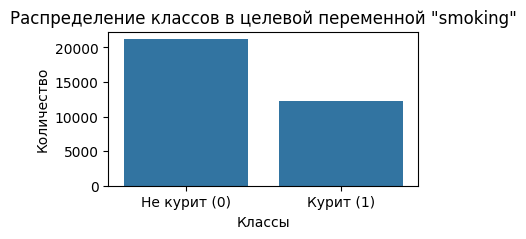

In [8]:
class_counts = df['smoking'].value_counts()

# Создание столбчатой диаграммы
plt.figure(figsize=(4, 2))
sns.barplot(x=class_counts.index, y=class_counts.values)

# Добавление подписей
plt.title('Распределение классов в целевой переменной "smoking"')
plt.xlabel('Классы')
plt.ylabel('Количество')
plt.xticks(ticks=[0, 1], labels=['Не курит (0)', 'Курит (1)'])  # Подписи для оси X
plt.show()

Классы не сбалансированы

In [9]:
# Разделение данных на признаки (X) и целевую переменную (y)
# X = df.drop(columns=['smoking', 'height_cm', 'waist_cm', 'hearing_left', 'hearing_right', 'eyesight_right', 'eyesight_left', 'weight_kg', 'ast', 'alt'])
X = df.drop(columns=['smoking'])
y = df['smoking']  # Целевая переменная
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
# Поиск лучших параметров
param_grid = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

model = DecisionTreeClassifier(random_state=42)

# GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [11]:
# # Лучшие параметры
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_  
print("Лучшие параметры:", best_params)
print("Лучшее значение accuracy:", best_accuracy)

Лучшие параметры: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Лучшее значение accuracy: 0.7230854367171953


In [12]:
# Обучение модели на лудших параметрах
# model_gs = DecisionTreeClassifier(random_state=42)
model_gs = DecisionTreeClassifier(**best_params)

model_gs.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [13]:
# Получение предсказанных меток классов на тестовой выборке
y_pred_test = model_gs.predict(X_test)
y_pred_train = model_gs.predict(X_train)

# Вычисление точности
accuracy_test = accuracy_score(y_test, y_pred_test)
accuracy_train = accuracy_score(y_train, y_pred_train)
print(f'accuracy train {accuracy_train:.4}')
print(f'accuracy test {accuracy_test:.4}')

# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred_test)
print('confusion matrix:')
print(conf_matrix)

# Логистическая потеря
y_pred_proba = model_gs.predict_proba(X_test)
log_loss_value = sk_log_loss(y_test, y_pred_proba)
print(f'log Loss: {log_loss_value:.4}')

# Расчет Gini-impurity для корневого узла
class_probabilities = np.mean(y_pred_proba, axis=0)
gini_impurity = model_gs.tree_.impurity[0] 
print(f'Gini-impurity для корневого узла: {gini_impurity:.4}')

accuracy train 0.7245
accuracy test 0.7219
confusion matrix:
[[5061 1283]
 [1509 2188]]
log Loss: 0.5226
Gini-impurity для корневого узла: 0.4638


### Анализ метрик: 
- accuracy на тренировочных данных =  0.7245, учитывая accuracy на тестовых данных =  0.7219 делаю вывод моедель не переодучена.
- Модель допускает значительное количество ошибок как FP, так и FN что указывает на то, что модель плохо разделяет классы.
- log Loss = 0.5226 умеренный показатель.
- Gini-impurity = 0.4689 данные в корневом узле неоднородны
### Общий вывод: 
- Можно предсказать курильщика на ~72%.
- точность нормальная, но есть куда развиваться, можно попробовать удалить выбросы и сбалансировать классы

In [14]:
# # Обрезка дерева (Дерево маленькое, обойдемся)
# path = model.cost_complexity_pruning_path(X, y)
# ccp_alphas = path.ccp_alphas

# optimal_ccp_alpha = ccp_alphas[-4]  
# pruned_model = DecisionTreeClassifier(ccp_alpha=optimal_ccp_alpha, random_state=42)
# pruned_model.fit(X, y)

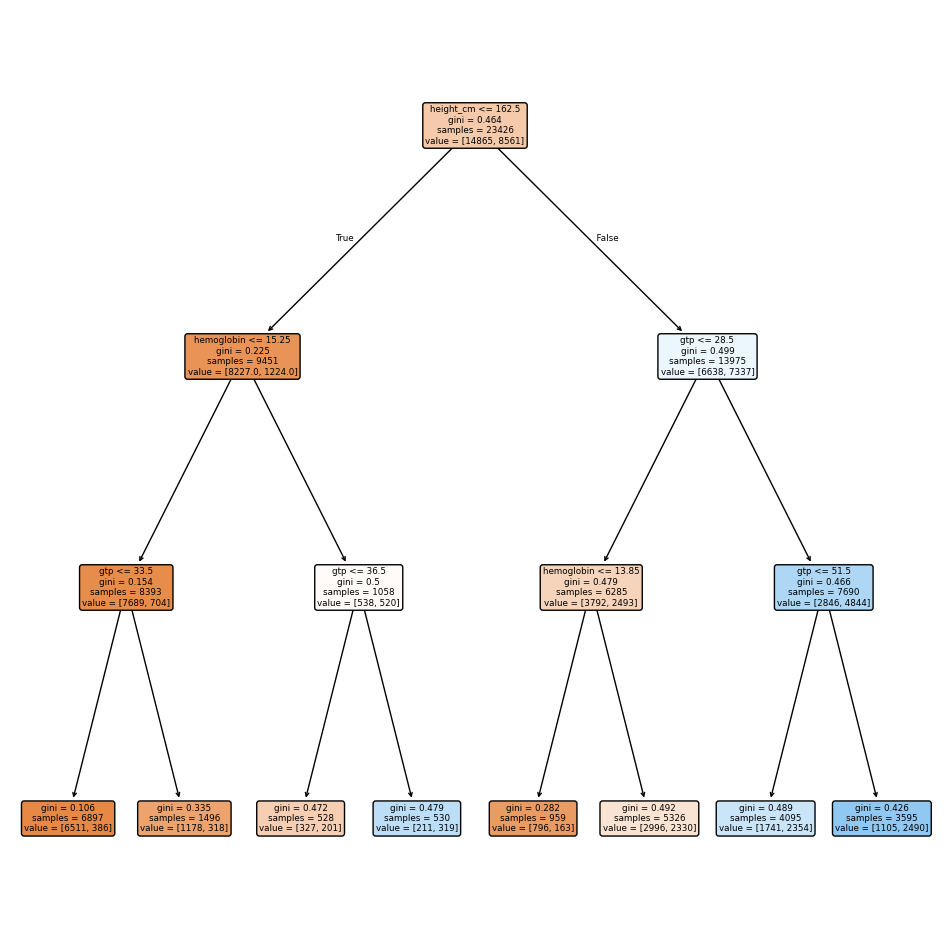

In [15]:
# Вывод дерева
plt.figure(figsize=(12, 12))
plot_tree(model_gs, feature_names=X.columns, filled=True, rounded=True)
plt.show()

In [16]:
# Выбор критериев влияющих на переменную с помощью feature_importances_
model = model_gs
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                Feature  Importance
1             height_cm    0.651346
20                  gtp    0.190407
15           hemoglobin    0.158247
3              waist_cm    0.000000
2             weight_kg    0.000000
0                   age    0.000000
5        eyesight_right    0.000000
4         eyesight_left    0.000000
6          hearing_left    0.000000
7         hearing_right    0.000000
10  fasting_blood_sugar    0.000000
11          cholesterol    0.000000
8              systolic    0.000000
9            relaxation    0.000000
13                  hdl    0.000000
12         triglyceride    0.000000
16        urine_protein    0.000000
14                  ldl    0.000000
17     serum_creatinine    0.000000
18                  ast    0.000000
19                  alt    0.000000
21        dental_caries    0.000000


Наибольший вес имеет height_cm, но маловероятно что он в жизни можно предсказать курение по росту. Выберу столбец gtp

In [17]:
# Построение модели дерева решений с 1 столбцов на входе и 1 столбцом на выходе
# Разделение данных на признаки (X) и целевую переменную (y)
X = df[['gtp']]
y = df['smoking']  # Целевая переменная
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
model_min = DecisionTreeClassifier(**best_params) # использую гиперпараметры базовой модели

model_min.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [19]:
# Получение предсказанных меток классов на тестовой выборке
y_pred_test = model_min.predict(X_test)
y_pred_train = model_min.predict(X_train)

# Вычисление точности
accuracy_test = accuracy_score(y_test, y_pred_test)
accuracy_train = accuracy_score(y_train, y_pred_train)
print(f'accuracy train {accuracy_train:.4}')
print(f'accuracy test {accuracy_test:.4}')

# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred_test)
print('confusion matrix:')
print(conf_matrix)

# Логистическая потеря
y_pred_proba = model_min.predict_proba(X_test)
log_loss_value = sk_log_loss(y_test, y_pred_proba)
print(f'log Loss: {log_loss_value:.4}')

# Расчет Gini-impurity для корневого узла (весь набор данных)
gini_impurity = model_min.tree_.impurity[0]
print(f'Gini-impurity для корневого узла: {gini_impurity:.4}')

accuracy train 0.6844
accuracy test 0.6801
confusion matrix:
[[4929 1415]
 [1797 1900]]
log Loss: 0.5886
Gini-impurity для корневого узла: 0.4638


Анализ метрик:
- Точность чуть выше среднего (ниже базовой модели).
- Низкая вероятность переобучения.
- Значительное количество ошибок.
- Логарифмическая потеря умеренная.
- Данные в корневом узле не однородны.

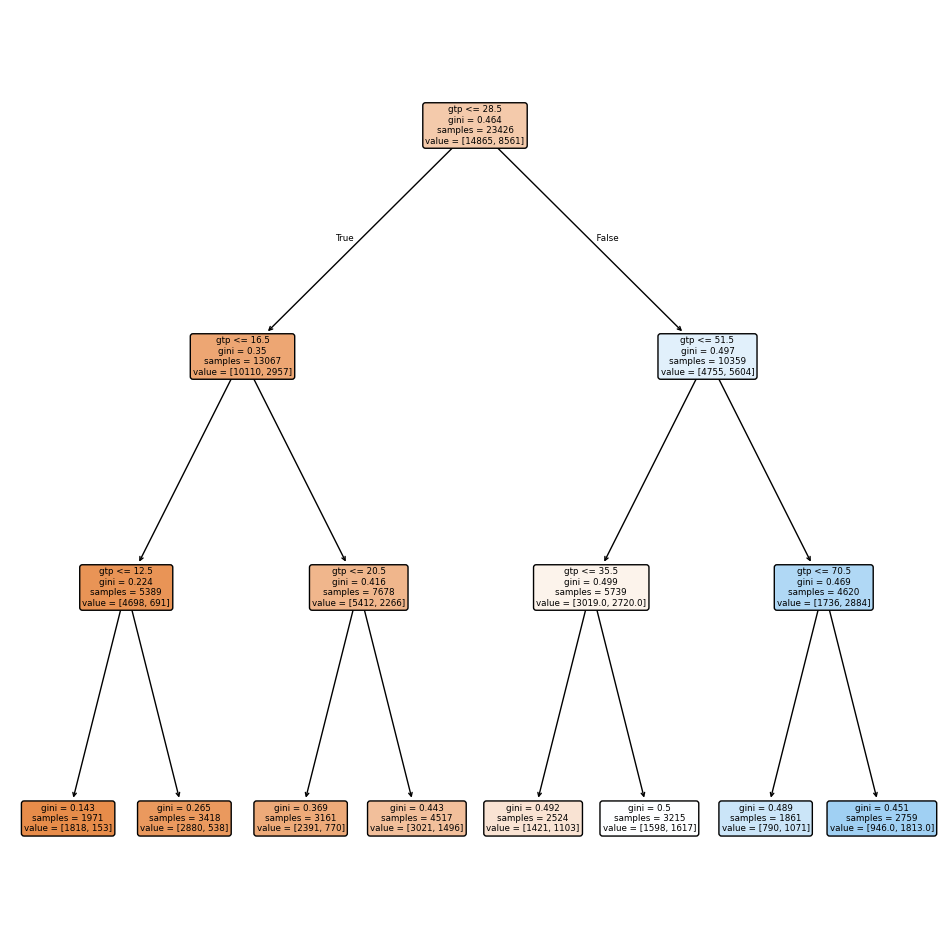

In [20]:
# Построение дерева для модели по одному столбцу на входе и одному столбцу на выходе
plt.figure(figsize=(12, 12))
plot_tree(model_min, feature_names=X.columns, filled=True, rounded=True)
plt.show()